In [16]:
from dataclasses import dataclass
import numpy as np
import re
from analysis_utils import *

@dataclass
class TaskRelease:
    task_graph: str
    name: str
    release_time: int
    deadline: int

@dataclass
class TaskGraphRelease:
    name: str
    release_time: int
    deadline: int
    nodes: int

extension = ".csv"
base_dir = "ray_osdi_12_1_evening"

fixed_policy = {}
poisson_policy = {}
gamma_policy = {}

for file_path in find_all_file_paths(base_dir, extension):
    file_name = file_path.split(os.sep)[-1]
    variables = extract_variables_from_filename(file_name)
    
    try:
        # Open the CSV file and read the last line
        with open(file_path, 'r') as file:
            lines = file.readlines()
        
        task_graph_release_time_map = {}
        if extension == ".csv":
            # This run failed
            # if "SIMULATOR_END" not in lines[-1]:
            #     continue
            task_release_time_map = {}
            for line in lines:
                if "TASK_RELEASE" in line:
                    # event_time should be the actual release time
                    event_time, _, task_name, _, task_intended_release_time, task_release_time, task_deadline, task_id, task_graph = line.strip().split(",")
                    # print(f"{task_name},{task_intended_release_time},{task_release_time},{task_deadline},{task_graph}")
                    event_time = int(event_time)
                    task_deadline = int(task_deadline)
                    task_release_time_map[task_graph + "-" + task_name] = TaskRelease(task_graph, task_name, event_time, task_deadline)
                elif "TASK_GRAPH_RELEASE" in line:
                    event_time, _, release_time, deadline, task_graph_name, number_of_nodes = line.strip().split(",")
                    task_graph_release_time_map[task_graph_name] = TaskGraphRelease(task_graph_name, int(release_time), int(deadline), int(number_of_nodes))
        elif extension == ".log":
            # Note: For now this only works for dry run log
            task_release_time_map = {}
            for i, line in enumerate(lines):
                if "will be released with deadline" not in line:
                    continue
                # Using re.findall to find all matches
                matches = re.findall(r'\b\d+\b', line)
                # Assuming you need the first match or a specific one
                release_time = int(matches[0]) if matches else None
                task_graph_release_time_map[str(i)] = TaskGraphRelease("", release_time, 0)
            
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"An error occurred while processing {file_path}: {str(e)}")

    release_policy = variables["release_policy"]
    max_deadline_variance = variables["max_deadline_variance"]
    
    if release_policy == "fixed":
        fixed_policy.setdefault(max_deadline_variance, {})
        fixed_policy[max_deadline_variance][file_name] = task_graph_release_time_map
    elif release_policy == "poisson":
        poisson_policy.setdefault(max_deadline_variance, {})
        poisson_policy[max_deadline_variance][file_name] = task_graph_release_time_map
    elif release_policy == "gamma":
        gamma_policy.setdefault(max_deadline_variance, {})
        gamma_policy[max_deadline_variance][file_name] = task_graph_release_time_map

alibaba_scheduler_EDF_release_policy_gamma_max_deadline_var_250_dag_aware_1_poisson_arrival_rate_0.01_gamma_coefficient_9.csv
arrival_rate (desired v.s. actual) = 0.01 v.s. 0.0113, cv2 (desired v.s. actual) = 9 vs 8.8031
alibaba_scheduler_TetriSched_release_policy_gamma_max_deadline_var_250_dag_aware_1_poisson_arrival_rate_0.01_gamma_coefficient_12_scheduler_discretization_1.csv
arrival_rate (desired v.s. actual) = 0.01 v.s. 0.0129, cv2 (desired v.s. actual) = 12 vs 11.6227
alibaba_scheduler_EDF_release_policy_gamma_max_deadline_var_250_dag_aware_1_poisson_arrival_rate_0.01_gamma_coefficient_10.csv
arrival_rate (desired v.s. actual) = 0.01 v.s. 0.0115, cv2 (desired v.s. actual) = 10 vs 9.3116
alibaba_scheduler_EDF_release_policy_gamma_max_deadline_var_250_dag_aware_1_poisson_arrival_rate_0.01_gamma_coefficient_14.csv
arrival_rate (desired v.s. actual) = 0.01 v.s. 0.0136, cv2 (desired v.s. actual) = 14 vs 12.9096
alibaba_scheduler_TetriSched_release_policy_gamma_max_deadline_var_250_dag

Text(0, 0.5, 'Task graph count')

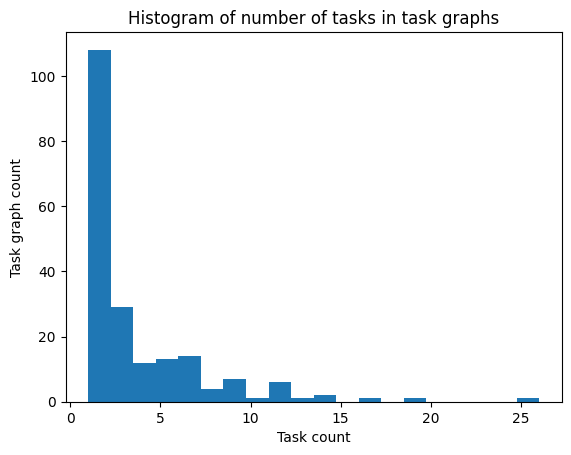

In [17]:
from collections import defaultdict

arrival_rate_dict = defaultdict(dict) #arrival_rate_dict[arrival_rate][cv2] = actual arrival rate
cv2_dict = defaultdict(dict) #cv2_dict[arrival_rate][cv2] = actual arrival rate
released_task_graph_num_nodes = {} # name -> 

for max_deadline_variance in gamma_policy:
    for file_name, task_graph_release_time_map in gamma_policy[max_deadline_variance].items():
        release_time = []
        current_released_task_graphs = {}
        for task_graph_release in task_graph_release_time_map.values():
            release_time.append(task_graph_release.release_time)
            current_released_task_graphs[task_graph_release.name] = task_graph_release.nodes
        avg_jobs_per_sec, cv2 = calculate_arrival_rate_and_cv2(release_time)
        variables = extract_variables_from_filename(file_name)
        print(file_name)
        print(f"arrival_rate (desired v.s. actual) = {variables['arrival_rate']} v.s. {avg_jobs_per_sec:.4f}, cv2 (desired v.s. actual) = {variables['cv2']} vs {cv2:.4f}")
 
        # Sanity check that the values are consistent across different runs
        if variables['arrival_rate'] in arrival_rate_dict and variables['cv2'] in arrival_rate_dict[variables['arrival_rate']]:
            assert arrival_rate_dict[variables['arrival_rate']][variables['cv2']] == round(avg_jobs_per_sec, 3)
            assert cv2_dict[variables['arrival_rate']][variables['cv2']] == round(cv2, 3)
        else:
            arrival_rate_dict[variables['arrival_rate']][variables['cv2']] = round(avg_jobs_per_sec, 3)
            cv2_dict[variables['arrival_rate']][variables['cv2']] = round(cv2, 3)

        if len(released_task_graph_num_nodes) == 0:
            released_task_graph_num_nodes = current_released_task_graphs
        else:
            assert len(released_task_graph_num_nodes) == len(current_released_task_graphs)
            for name, task_graph_release in released_task_graph_num_nodes.items():
                assert name in current_released_task_graphs
                

plt.hist(released_task_graph_num_nodes.values(), bins=20)
plt.title("Histogram of number of tasks in task graphs")
plt.xlabel("Task count")
plt.ylabel("Task graph count")